In [1]:
import folium
from folium import plugins
from folium.plugins import MeasureControl
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import branca.colormap as cm

In [2]:
# Loading data
path ="C:/Users/elain/Desktop/MBAN/Geotab"
geo=pd.read_csv("%s/bigqueryresults.csv" %path)
geo["AREA_NAME", "AREA_ID"] =""
traffic_camera=pd.read_csv("%s/tmcearthcameras.csv" %path)
shapefile = gpd.read_file("%s/CityWard/WARD_WGS84.shp" %path)
traffic_camera["Intersection"] = traffic_camera["Main Road"].map(str) + " & "+traffic_camera["Cross Street"]
top10 = geo.loc[geo.SeverityScore >= geo.SeverityScore.quantile(0.9)]

# classify each point in Geotab Hazardous Driving Areas dataset to its corresponding cityward
for record in range(len(geo)):
    p1 = Point(list(geo[['Longitude','Latitude']].loc[record]))
    for index in range(len(shapefile)):
        poly = shapefile["geometry"][index]
        if p1.within(poly)==True:
            geo.loc[record,"AREA_NAME"] = shapefile["AREA_NAME"].loc[index]
            geo.loc[record,"AREA_ID"] = shapefile["AREA_ID"].loc[index].astype(int)

geo_summary = geo.groupby("AREA_NAME").agg(
    {'IncidentsTotal':'sum', 'SeverityScore':'mean','AREA_ID':'mean'})

In [57]:
camera_location_list = traffic_camera[["Latitude","Longitude"]].values.tolist()
camera_name_list= traffic_camera[["Intersection"]].values.tolist()


m_Toronto= folium.Map([geo.Latitude_SW.mean(), geo.Longitude_SW.mean()],
              height=1000, zoom_start=11, tiles='OpenStreetMap')
m_Toronto.add_child(MeasureControl())

# add choropleth map

bins = list(geo_summary['IncidentsTotal'].quantile([0, 0.25, 0.5, 0.75, 1]))
folium.Choropleth(geo_data=shapefile,
    name='Toronto City Wards',
    data=geo_summary,
    columns=['AREA_ID', 'IncidentsTotal'],
    key_on='feature.properties.AREA_ID',
    fill_color='YlGn',
    line_color = 'black', line_width = 5,
    fill_opacity=0.1,
    bins=bins,
    highlight=True,overlay=True,
    legend_name='Incident Counts').add_to(m_Toronto)


# add a layer for traffic camera
fg=folium.FeatureGroup(name="All Traffic Cameras", show=False)
for each in traffic_camera.index:
    icon_camera = plugins.BeautifyIcon(
        icon_shape='circle',
        icon='camera',
        border_color='blue', background_color='white')
    popup=folium.Popup(camera_name_list[each],parse_html=True)
    fg.add_child(folium.Marker(
        location=camera_location[each],
        popup=popup,
        icon=icon_camera)).add_to(m_Toronto)
m_Toronto.add_child(fg)  

# add a layer for geohash
fg1=folium.FeatureGroup(name="All Hazardous Driving Areas", show=False)
for each in geo.index:
    bounds = list(geo[['Latitude_SW','Longitude_SW']].loc[each]),list(geo[['Latitude_NE','Longitude_NE']].loc[each])
    folium.vector_layers.Rectangle(bounds,fill_color='blue', fill_opacity=0.7).add_to(fg1)
fg1.add_child(plugins.HeatMap(zip(geo['Latitude'],geo['Longitude'],geo['SeverityScore']), radius = 10)) 
m_Toronto.add_child(fg1)


# add a layer for top 10% of hazardous driving areas
fg2=folium.FeatureGroup(name="Top 10%: Hazardous Driving Areas", show=True)
for each in top10.index:
    bounds = list(top10[['Latitude_SW','Longitude_SW']].loc[each]),list(top10[['Latitude_NE','Longitude_NE']].loc[each])
    folium.vector_layers.Rectangle(bounds,fill_color='blue', fill_opacity=0.7).add_to(fg2)
fg2.add_child(plugins.HeatMap(zip(top10['Latitude'],top10['Longitude'],top10['SeverityScore']), radius = 10)) 
m_Toronto.add_child(fg2)


# add a layer for aggregated traffic camera
fg3=folium.FeatureGroup(name="Aggregate Traffic Cameras", show=True)
plugins.MarkerCluster(np.array(traffic_camera[["Latitude", "Longitude"]]), 
                      popups = camera_name_list,
                      name = "Traffic Cameras").add_to(fg3)
m_Toronto.add_child(fg3)


#folium.LayerControl().add_to(m_Toronto)
m_Toronto.add_child(folium.LayerControl())
    
m_Toronto.save("Safety_Toronto.html")
m_Toronto

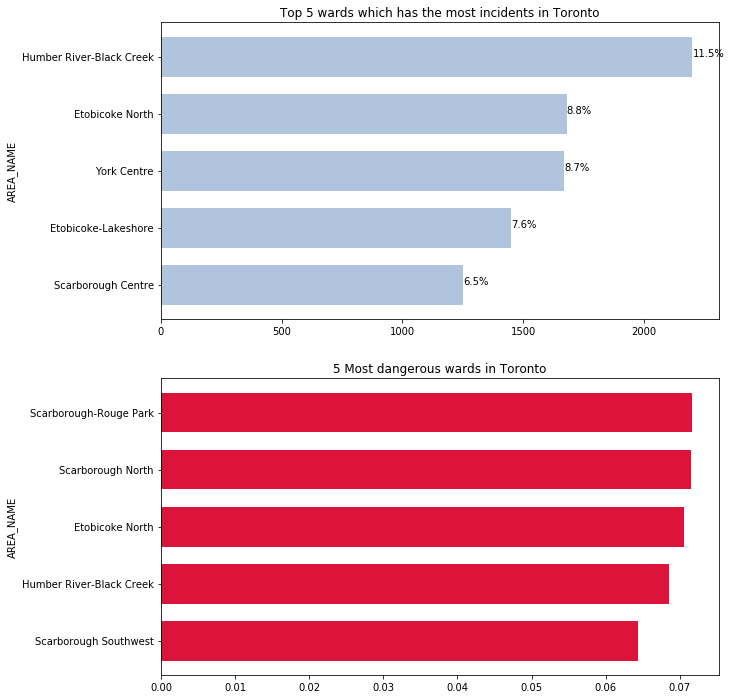

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
ax = plt.subplot(2,1,1)
ax = geo_summary.sort_values(by=["IncidentsTotal"], ascending = False)["IncidentsTotal"][:5].plot(
    kind='barh', width = 0.7, color='lightsteelblue')
ax.invert_yaxis()
plt.title('Top 5 wards which has the most incidents in Toronto')
for i in range(5):
    ax.text(geo_summary.sort_values(by=["IncidentsTotal"],ascending = False).iloc[i,0], i,
        '{:.1%}'.format(geo_summary.sort_values(
            by=["IncidentsTotal"],ascending=False).iloc[i,0] /geo_summary["IncidentsTotal"].sum()),
            color='black')
    ax.set_yticklabels(geo_summary.sort_values(by=["IncidentsTotal"], ascending = False).index[:5])

ax1 = plt.subplot(2,1,2)
ax1 = geo_summary.sort_values(by=["SeverityScore"], ascending = False)["SeverityScore"][:5].plot(
    kind='barh', width = 0.7, color='#DC143C')
ax1.invert_yaxis()
plt.title('5 Most dangerous wards in Toronto')
for i in range(5):
    ax1.set_yticklabels(geo_summary.sort_values(by=["SeverityScore"], ascending = False).index[:5])  